# Using symmetry in the problems to make quantum computing more efficient
We can use quantum computers to help us with machine learning. By utilizing variational quantum circuits, we can use quantum computers to learn patterns in data.

In order for this to work well, we need to come up with a way to encode the patterns we want to learn into the quantum computer. Especially on near-term quantum hardware, this requires quite some resources. One way to reduce these resource requirements and learn more efficiently is to take advantage of symmetries in the data we are trying to learn.

One approach is taken in [this paper](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.4.010328) (CC-BY 4.0, Johannes Jakob Meyer, Marian Mularski, Elies Gil-Fuster, Antonio Anna Mele, Francesco Arzani, Alissa Wilms, and Jens Eisert) and we will use it as a guideline for this challenge. A huge thank you to the authors for providing this idea and explaing it so well :-)

# Basic code to work with the Tic-Tac-Toe example

The following code cells will provide you with some tools you can use to generate data from tic-tac-toe that you can use to train your variational quantum circuit.

The helper function generate tic-tac-toe board positions or help determine the winner.

In [105]:
# helper function to determine valid tic tac toe board positions
def get_winner(board):
        # Check the board for any winning combinations
    winning_combinations = [
        # Rows
        (0, 1, 2),
        (3, 4, 5),
        (6, 7, 8),
        # Columns
        (0, 3, 6),
        (1, 4, 7),
        (2, 5, 8),
        # Diagonals
        (0, 4, 8),
        (2, 4, 6),
    ]
    
    x_wins = False
    o_wins = False
    
    for combo in winning_combinations:
        if board[combo[0]] == board[combo[1]] == board[combo[2]] and board[combo[0]] != '':
            if board[combo[0]] == 'x':
                return [0,0,1]
            else:
                return [1,0,0]
    return [0,1,0]
    

def is_valid_tic_tac_toe(board):
    # Check that the board has exactly 9 elements
    if len(board) != 9:
        return False
    
    # Count the number of 'x' and 'o' on the board
    count_x = board.count('x')
    count_o = board.count('o')
    
    # Check that the difference in count between 'x' and 'o' is 0 or 1
    if abs(count_x - count_o) > 1:
        return False
    
    # Check the board for any winning combinations
    winning_combinations = [
        # Rows
        (0, 1, 2),
        (3, 4, 5),
        (6, 7, 8),
        # Columns
        (0, 3, 6),
        (1, 4, 7),
        (2, 5, 8),
        # Diagonals
        (0, 4, 8),
        (2, 4, 6),
    ]
    
    x_wins = False
    o_wins = False
    
    for combo in winning_combinations:
        if board[combo[0]] == board[combo[1]] == board[combo[2]] and board[combo[0]] != '':
            if board[combo[0]] == 'x':
                x_wins = True
            else:
                o_wins = True
    
    # Check if both 'x' and 'o' won or if neither won
    if x_wins and o_wins: # or (not x_wins and not o_wins):
        return False
    
    # Check that the board is a valid final board configuration
    if (x_wins and count_x != count_o + 1) or (o_wins and count_x != count_o):
        return False
    # All checks have passed, so the board is valid
    return True
  

In [106]:
def generate_tic_tac_toe_configs():
    valid_configs = []
    winners = []
    
    # Generate all possible configurations of the board
    for i in range(3**9):
        board = []
        for j in range(9):
            symbol = ''
            if i % 3 == 0:
                symbol = 'x'
            elif i % 3 == 1:
                symbol = 'o'
            board.append(symbol)
            i //= 3
        
        # Check if the configuration is valid
        if is_valid_tic_tac_toe(board):
            valid_configs.append(board)
            winners.append(get_winner(board))
    
    return valid_configs, winners

In [107]:
boards, winners = generate_tic_tac_toe_configs()
print("boards: ", boards[1:5])
print("winners: ",  winners[1:5])
print(len(boards))
print(len(winners))

boards:  [['o', 'x', 'o', 'o', 'o', 'x', 'x', 'x', 'x'], ['x', 'o', 'o', 'o', 'o', 'x', 'x', 'x', 'x'], ['', '', 'o', 'o', 'o', 'x', 'x', 'x', 'x'], ['', 'o', '', 'o', 'o', 'x', 'x', 'x', 'x']]
winners:  [[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]]
7591
7591


## Building the circuit

Now it is time to build the circuit. For this, we will start with some basic imports. For todays challenge, we use qiskit. However, this can be also acchieved with PennyLane or Cirq.


In [108]:
!pip install qiskit



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
boards[30]

['x', '', 'o', '', 'o', 'o', 'x', 'x', 'x']

In [91]:
index_lst = []
for i in range(len(winners)):
    if winners[i] == [0,1,0]:
        index_lst.append(i)

print(winners[index_lst[10]],boards[index_lst[10]])

IndexError: list index out of range

In [63]:
import numpy as np
from qiskit import *

### Encoding the data

The basic element needed for your first program is the QuantumCircuit. We begin by creating a `QuantumCircuit` comprised of nine qubits.

The equivariant embedding is constructed by encoding the different numerical values that represent a game via a Pauli-X rotation on separate qubits that we view in a planar grid. To distribute the three data features equidistantly, we use a multiple of 2π/3 for the rotation angle, again as shown in the second column of Fig. 3.


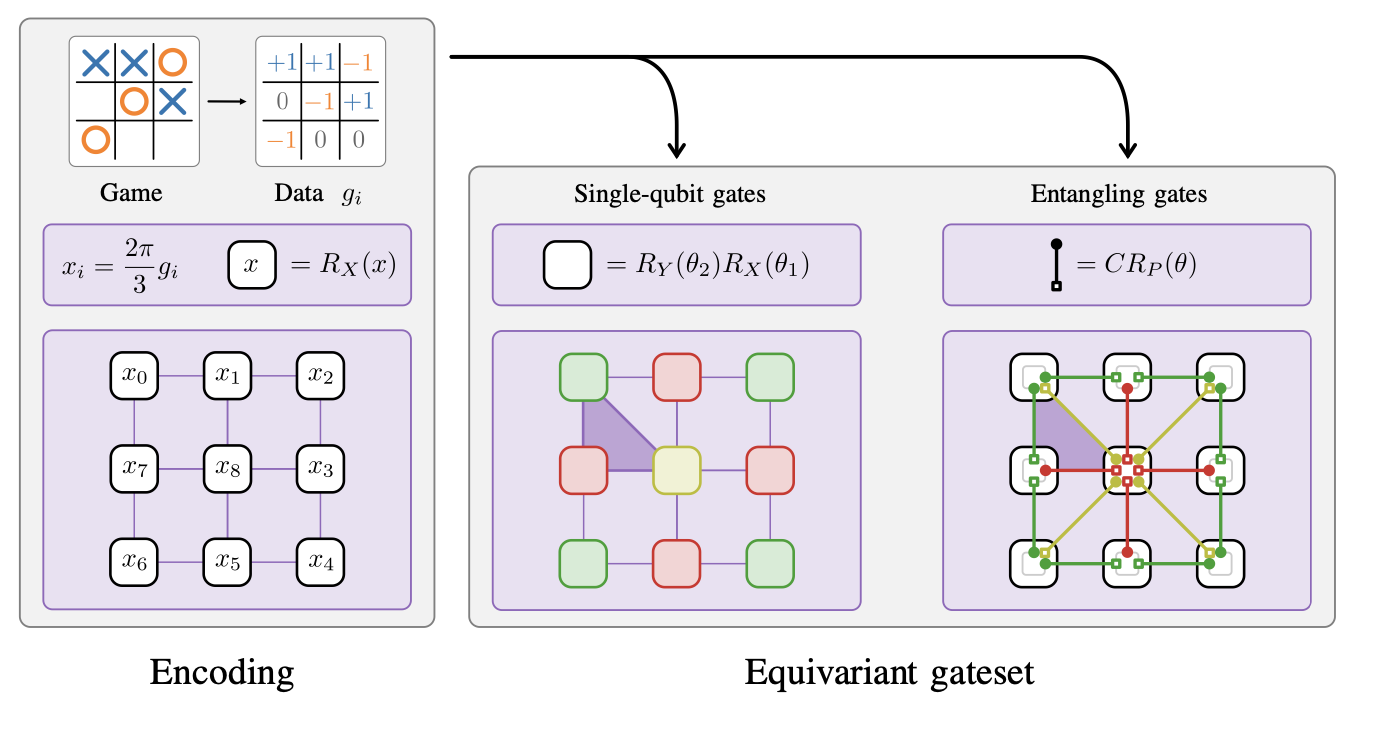

In [109]:
# tic_tac_toe_field = ['x','x','o','','o','x','o','','']
def encode_data(tic_tac_toe_field, circuit):
    data_g = [1 if entry == 'x' else -1 if entry == 'o' else 0 for entry in tic_tac_toe_field ]
    for entry, index in zip(data_g, range(len(data_g))):
        circuit.rx(entry * 2 * np.pi / 3, index)
                   
    return circuit

In [110]:
def add_single_qubit_gates(params, circuit):
    corner_qubits = [0,2,6,8]
    edge_qubits = [1,3,5,7]
    center_qubit = 4
    # corners (green)
    for i in corner_qubits:
        circuit.rx(params[0],i)
        circuit.ry(params[1],i)
    # edges (red)
    for i in edge_qubits: 
        circuit.rx(params[2],i)
        circuit.ry(params[3],i)
    # middle (yellow)
    circuit.rx(params[4],center_qubit)
    circuit.rx(params[5],center_qubit)
    return circuit

In [111]:
def add_two_qubit_gates(params, circuit):
    # corners (green)
    corner_qubits = [0,2,6,8]
    edge_qubits = [1,3,5,7]
    center_qubit = 4 
    # yellow two-qubit gates
    for i in corner_qubits:
        circuit.cry(params[0],center_qubit,i)
        
    # red two-qubit gates
    for i in edge_qubits: 
        circuit.cry(params[1],i,center_qubit)
    
    # green two-qubit gates
    circuit.cry(params[2],0,1)
    circuit.cry(params[2],0,3)
    circuit.cry(params[2],2,1)
    circuit.cry(params[2],2,5)
    circuit.cry(params[2],6,3)
    circuit.cry(params[2],6,7)
    circuit.cry(params[2],8,5)
    circuit.cry(params[2],8,7)
    
    return circuit

In [112]:
# Create a Quantum Circuit acting on a quantum register of nine qubits
circ = QuantumCircuit(9)

encode_data(['x','x','o','','o','x','o','',''], circ)

circ.barrier()

single_qubit_gate_params=[0.2,0.3,0.2,0.4,0.5, 0.6]
add_single_qubit_gates(single_qubit_gate_params, circ)

circ.barrier()

two_qubit_gate_params=[0.2,0.3,0.2]
add_two_qubit_gates(two_qubit_gate_params, circ)

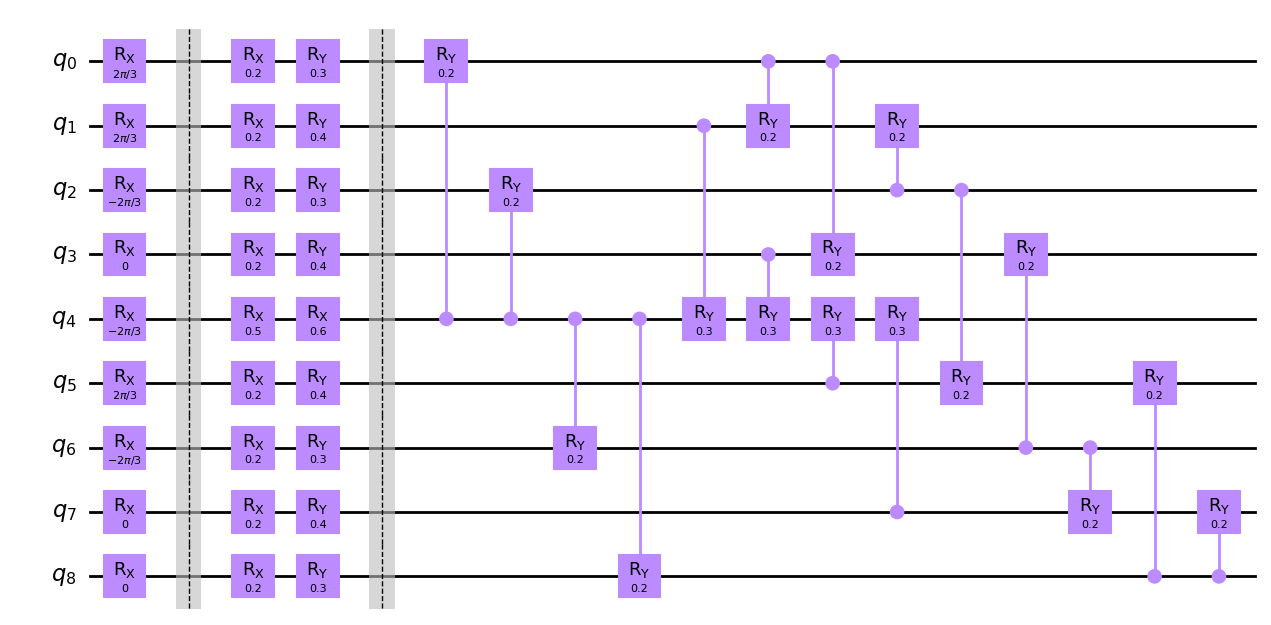

In [113]:
circ.draw(output='mpl')

# Measure expectation value

Of course, we want to use this circuit and use it to learn to predict who was winning a given Tic-Tac-Toe board.

In [114]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator

estimator = Estimator()

circuits = (
    circ,
    circ,
    circ
)
observables = (
    SparsePauliOp("ZIZIZIZII") / 4.0,
    SparsePauliOp("IZIZIZIZI") / 4.0,
    SparsePauliOp("IIIIIIIIZ")
)

job = estimator.run(circuits, observables)
result = job.result()

print(f">>> Observables: {[obs.paulis for obs in observables]}")
print(f">>> Expectation values: {result.values.tolist()}")

>>> Observables: [PauliList(['ZIZIZIZII']), PauliList(['IZIZIZIZI']), PauliList(['IIIIIIIIZ'])]
>>> Expectation values: [0.011603769581653978, 0.04297566131888242, -0.6208035024302354]


# Train
Now that we have our circuit, however, the results obtained are not quite what we wanted. So, we still need to train it on the given data. 

Therefore, we need to define, how far we are away from the expected result. One way to do this, is to use the l2_loss function.

In [115]:
# Define the loss function
def l2_loss(output, target):
    output, target = np.array(output), np.array(target)
    return np.sum(np.abs(output - target)**2)

In [116]:
l2_loss(result.values.tolist(), winners[1])

2.628985548424417

In [117]:
winners

[[0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 1, 0],
 [1, 0, 0],
 [0, 1, 0],
 [1, 0, 0],
 [0,

Split data into test and train data

In [118]:
x = boards
y = winners

# shuffle the indices
shuffle_indices = np.random.permutation(len(x))
train_size = int(len(x) * 0.7)

# split the indices into training and testing sets
train_indices = np.array(shuffle_indices[:train_size])
test_indices = np.array(shuffle_indices[train_size:])

# create the training and testing sets
x_train, y_train = np.take(x, train_indices, axis=0), np.take(y, train_indices, axis=0)
x_test, y_test = np.take(x, test_indices, axis=0), np.take(y, test_indices, axis=0)

print("Example train data: ", x_train[17], y_train[17])

Example train data:  ['' 'x' 'x' 'o' '' 'o' '' '' ''] [0 1 0]


In [119]:
# Define the optimizer
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
        
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
from qiskit.algorithms.optimizers import SPSA


# Define the cost function to be minimized by the optimizer
def cost_function(params, data, labels):
    y = labels
    # TODO: Calculate the cost and return them
    cost = 0
    
    for i in range(len(data)):
        output = predict(data[i],params)
        output = np.abs(output)
        #pos = np.argmax(np.abs(output))
        #output = np.zeros(3)
        #output[pos] = 1
        cost += l2_loss(output, y[i])
    return cost/len(data)

# Initialize the parameters
params = np.random.rand(9)*2*np.pi

# Train the circuit
print('Initial parameters:', params)


# Check the qiskit docs to figure out how to start an optimizer

Initial parameters: [1.29216764 3.92824769 6.16225941 1.6762047  0.14341516 5.30545087
 1.01302433 5.95209463 5.61126774]


In [121]:
len(x_train)//100

53

0
0


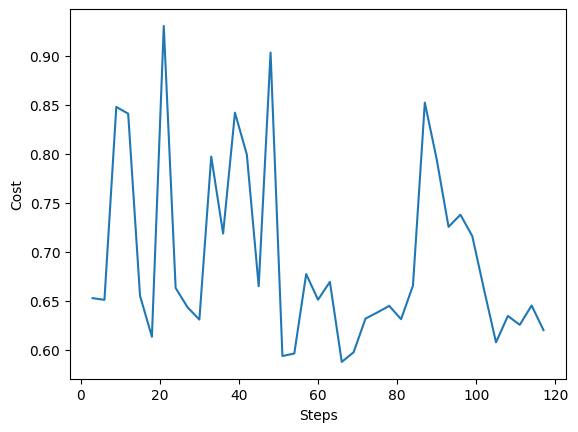

1


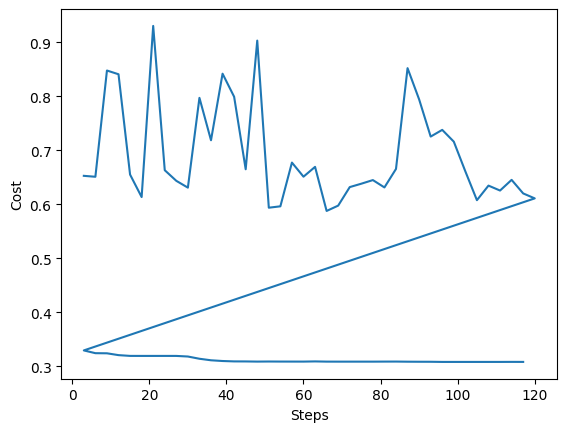

2


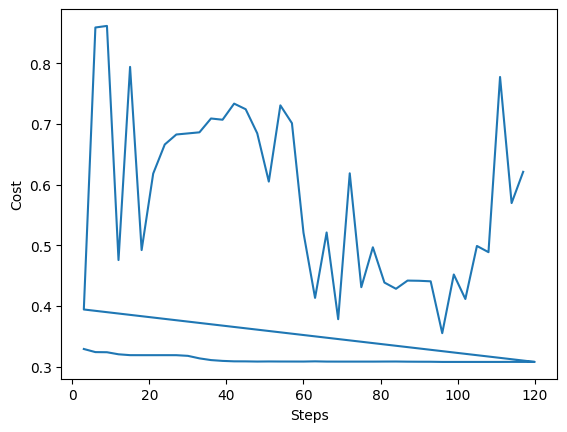

3


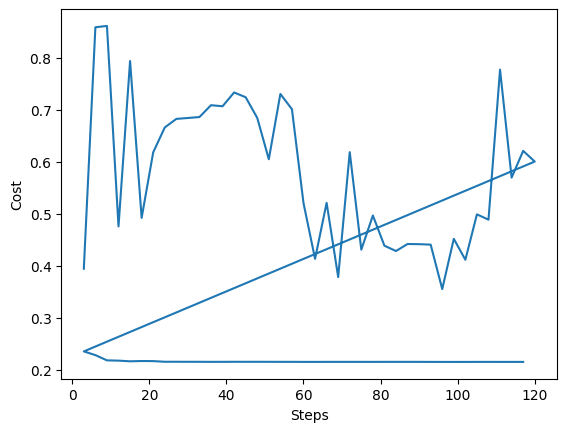

4


KeyboardInterrupt: 

In [126]:
parameters_list = []
k = 0
log = OptimizerLog()
optimizer = SPSA(maxiter=40, callback=log.update)
while k < 10:
    print(k)
    k= k+1
    shuffle_indices = np.random.permutation(len(x_train))
    train_indices = np.array(shuffle_indices)
    # create the training and testing sets
    x_train_sh, y_train_sh = np.take(x_train, train_indices, axis=0), np.take(y_train, train_indices, axis=0)
    j = 0
    while j < 100: 
        print(j)
        num_lim = len(x_train)//100
        if j<19:
            x_train1 = x_train_sh[j*num_lim:(j+1)*num_lim]
            y_train1 = y_train_sh[j*num_lim:(j+1)*num_lim]
        else: 
            x_train1 = x_train_sh[j*num_lim:]
            y_train1 = y_train_sh[j*num_lim:]

        def objective_function(variational):
            """Cost function of circuit parameters on training data.
            The optimizer will attempt to minimize this."""
            return cost_function(variational,x_train1, y_train1)
        j = j+1
        result = optimizer.minimize(fun=objective_function,x0= params)

        params = result.x
        opt_val = result.fun
        parameters_list.append(params)
        import matplotlib.pyplot as plt
        fig = plt.figure()
        plt.plot(log.evaluations, log.costs[-80:-1])
        plt.xlabel('Steps')
        plt.ylabel('Cost')
        plt.show()

## Use the model
The final model can then be used to predict the winner for any given tic-tac-toe board.

In [127]:
params

array([ 15.42876562, -11.29391378, -11.87713908,   1.21463851,
       -13.38695298,  13.37245095,   0.88885072,  12.59590057,
        -8.28368898])

In [19]:
def predict(data, params):
    circ = QuantumCircuit(9)
    circ.params = params
    encode_data(data, circ)
    circ.barrier()
    add_single_qubit_gates(params[0:6], circ)
    circ.barrier()
    add_two_qubit_gates(params[6:9], circ)

    estimator = Estimator()
    circuits = (
        circ,
        circ,
        circ
    )
    observables = (
        SparsePauliOp("ZIZIIIZIZ") / 4.0,
        SparsePauliOp("IZIZIZIZI") / 4.0,
        SparsePauliOp("IIIIZIIII")
    )

    job = estimator.run(circuits, observables)
    result = job.result()
    results = result.values.tolist()
    exp_val_o = results[0]
    exp_val_draw = results[2]
    exp_val_x = results[1]

    return [exp_val_o, exp_val_draw, exp_val_x]

In [ ]:
test_board = ['x','x','o','','o','x','o','','']
output = predict(test_board, params)
target_output = [[0,0,1]]
print('Target output:', target_output)
print('Circuit output:', output)
print('L2 loss:', l2_loss(output, target_output))

In [128]:
preds = []
for i in range(len(x_test)):
    preds.append(predict(x_test[i],params))

In [129]:
preds_1 =[]
y_test1 = []
for i in range(len(preds)):
    pos = np.argmax(preds[i])
    preds[i] = list(-1*np.ones(3))
    preds[i][pos] = 1
    preds_1.append(pos)
    pos1 = np.argmax(y_test[i])
    y_test1.append(pos1)
preds = np.array(preds)


In [130]:
set(y_test1)

{0, 1, 2}

In [131]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
f1_score(y_test1,preds_1, average='weighted')


0.5297207039446574

In [132]:
confusion_matrix(y_test1,preds_1)

array([[ 37,  10,  32],
       [618, 832, 566],
       [ 57,  33,  93]], dtype=int64)

# Further tasks
Of course, this is just a simple example of using symmetry within problems to make quantum machine learning more efficient.

The first step, is to complete the circuit construction and the training loop above. Also, you might want to make this circuit more efficient to run faster :-)

You can take this further with one of the following ideas:
 - Implement a noninvariant VQA and compare with the invariant one
 - Investigate the dependence on connectivity
 - Come up with problems with different symmetries
 - Analyze how noise affects the VQA
 - ...

In [29]:
y_test[0]

array([0, 1, 0])

In [30]:
x_test[0]

array(['o', 'o', '', 'o', '', 'x', 'x', '', ''], dtype='<U1')